# **Controlador de Teoría de Juegos Evolutiva - EGT**

#### **1. Marco Conceptual y Filosofía de Diseño**

El controlador implementado se basa en los principios de la **Teoría de Juegos Evolutiva (EGT)**, específicamente en el modelo de las **Dinámicas de Replicador (Replicator Dynamics)**. La filosofía central es modelar el problema de control no como una optimización centralizada, sino como un sistema descentralizado de agentes que compiten y cooperan por un recurso limitado.

*   **Problema:** Distribuir eficientemente un recurso finito (la potencia térmica total disponible, $U_{MAX\_TOTAL}$) entre cuatro habitaciones para que cada una alcance su temperatura de referencia individual.
*   **Enfoque EGT:** En lugar de un "cerebro" central, tratamos a cada habitación como una "población de jugadores" que puede adoptar una de cuatro estrategias: "calentar la Habitación 1", "calentar la Habitación 2", etc. La "popularidad" de cada estrategia (la proporción de la población que la adopta) evoluciona en el tiempo basándose en su rendimiento.

Este enfoque produce un comportamiento de control **emergente**, donde la distribución óptima de la potencia no se calcula explícitamente, sino que surge de la interacción dinámica de los agentes.

#### **2. Componentes Fundamentales del Juego**

Para aplicar la EGT, definimos los siguientes tres elementos clave:

**a) Jugadores y Estrategias:**
*   **Jugadores:** Existe una población de "jugadores" virtuales.
*   **Estrategias ($x$):** Las estrategias no son la potencia en sí, sino la **proporción de la población** que se dedica a calentar cada habitación. Esto se representa con el vector de proporciones $x(t) = [x_1(t), x_2(t), x_3(t), x_4(t)]^T$, donde:
    *   $x_i(t)$ es la fracción de la potencia total asignada a la Habitación $i$.
    *   Este vector siempre debe cumplir la condición de que sus componentes son no-negativos ($x_i \ge 0$) y su suma es igual a 1 ($\sum_{i=1}^{4} x_i(t) = 1$).

**b) Función de Pago (Fitness):**
El "pago" o "fitness" ($p_i$) es la métrica que cuantifica el rendimiento de cada estrategia. Es el componente más crítico para la estabilidad y precisión del controlador. Tras un proceso de sintonización, se implementó una **función de pago asimétrica** basada en el error de seguimiento.

*   **Ecuación 1: Función de Pago Asimétrica**
    $$
    p_i(t) = T_{ref,i} - T_i(t)
    $$
    *   **Explicación:** El pago es simplemente el error de temperatura.
        *   Si la habitación está **demasiado fría** ($T_i < T_{ref,i}$), el error es positivo, resultando en un **pago positivo**. Esto crea un fuerte incentivo para que la proporción $x_i$ crezca y se asigne más potencia.
        *   Si la habitación está **demasiado caliente** ($T_i > T_{ref,i}$), el error es negativo, resultando en un **pago negativo**. Esto actúa como una penalización, forzando a la proporción $x_i$ a disminuir drásticamente.
        *   Si la temperatura es **perfecta** ($T_i = T_{ref,i}$), el pago es cero.

    Esta función asimétrica fue crucial para corregir el error de estado estacionario, ya que diferencia claramente entre la necesidad de calentar y la necesidad de dejar de hacerlo.

**c) Dinámica Evolutiva (El "Motor" del Controlador):**
La evolución de las proporciones $x_i$ se rige por la ecuación de las **Dinámicas de Replicador**. La intuición es simple: las estrategias que rinden por encima del promedio de la población crecen en popularidad, mientras que las que rinden por debajo, disminuyen.

*   **Ecuación 2: Dinámica del Replicador (Forma Continua)**
    $$
    \frac{dx_i}{dt} = x_i \cdot (p_i - \bar{p})
    $$
    Donde $\bar{p} = \sum_{j=1}^{4} (x_j \cdot p_j)$ es el pago promedio de toda la población.

#### **3. Implementación en el Controlador Discreto**

Dado que la simulación se ejecuta en un bucle de lazo cerrado con pasos de tiempo discretos ($\Delta t$), las ecuaciones continuas se implementan de forma discreta dentro de la clase `ControladorTeoriaJuegos`.

**a) Proceso de Cálculo en Cada Iteración:**

1.  **Medir Estado:** El controlador recibe las temperaturas actuales $T_{actuales}$.
2.  **Calcular Pagos:** Se aplica la Ecuación 1 para obtener el vector de pagos $p$.
3.  **Actualizar Proporciones:** Se utiliza el método de **integración de Euler** para actualizar el vector de proporciones $x$.

*   **Ecuación 3: Actualización Discreta de las Proporciones**
    $$
    x_i[k+1] = x_i[k] + K_{\text{replicator}} \cdot \Delta t \cdot \big(x_i[k] \cdot (p_i[k] - \bar{p}[k])\big)
    $$
    *   $x_i[k]$: Proporción en el instante de tiempo actual.
    *   $\Delta t$: El paso de tiempo de la simulación.
    *   $K_{\text{replicator}}$: Una **ganancia de sintonización** que ajusta la "agresividad" o velocidad de reacción del controlador. Un valor más bajo (0.005 en la versión final) produce una respuesta más suave y estable.

4.  **Garantizar la Estabilidad Numérica (Normalización):**
    Después de la actualización, es posible que por errores numéricos, la suma de las $x_i$ ya no sea exactamente 1. Se aplica un paso de corrección crucial.

*   **Ecuación 4: Normalización**
    $$
    x_{i, \text{norm}}[k+1] = \frac{x_i[k+1]}{\sum_{j=1}^{4} x_j[k+1]}
    $$
    Este paso fuerza a que el vector de proporciones siempre cumpla la restricción $\sum x_i = 1$, evitando inestabilidades y "fugas" numéricas.

5.  **Calcular la Acción de Control Final:**
    Una vez que se tiene el vector de proporciones actualizado y normalizado, la potencia a aplicar en cada habitación se calcula de forma directa.

*   **Ecuación 5: Cálculo de la Potencia de Control**
    $$
    u_i(t) = x_i(t) \cdot U_{MAX\_TOTAL}
    $$
    Donde $U_{MAX\_TOTAL}$ se sintonizó a 6200 W para lograr el balance óptimo entre tiempo de respuesta y evitar el sobrecalentamiento.

#### **4. Resumen del Desempeño Logrado**

El controlador final, gracias a la combinación de la **función de pago asimétrica** y la **cuidadosa sintonización** de las ganancias ($K_{\text{replicator}}$ y $U_{MAX\_TOTAL}$), exhibe un comportamiento de alto rendimiento:

*   **Precisión:** Alcanza las temperaturas de referencia con un error mínimo ($< 0.05^\circ C$).
*   **Estabilidad:** La respuesta es suave, sin sobreimpulsos significativos y con oscilaciones iniciales que se amortiguan rápidamente.
*   **Eficiencia:** La acción de control es continua y estable, evitando el desgaste de los actuadores. La potencia se distribuye de manera inteligente, asignando más recursos a las habitaciones con mayores pérdidas térmicas, un comportamiento que emerge naturalmente de la dinámica del juego.

En conclusión, el controlador implementado es un excelente ejemplo de cómo los principios de sistemas multi-agente y la teoría de juegos evolutiva pueden ser aplicados para resolver problemas complejos de asignación dinámica de recursos en ingeniería de control.

### Fase 0: Configuración del Entorno

Mantenemos las mismas librerías. No hay cambios aquí.

In [1]:
# Fase 0: Importar las librerías necesarias
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

print("Fase 0: Entorno configurado.")

Fase 0: Entorno configurado.


### Fase 1: Definir Parámetros del Sistema y del Controlador

Aquí también, los parámetros físicos son los mismos. Añadiremos una **ganancia `K_replicator`** a nuestro controlador, que nos permitirá "sintonizar" qué tan rápido reacciona a los cambios en el rendimiento (pagos). Esto es crucial para la estabilidad.

In [2]:
# Fase 1: Definir constantes y parámetros

# ---- Parámetros Térmicos del Sistema (del enunciado) ----
C = 7.476e4      # Capacitancia térmica [J/°C]
ALPHA = 123.6    # Conductancia térmica [W/°C]
T_A = 8.0        # Temperatura ambiente [°C]

# ---- Parámetros de Simulación (inspirado en Entrega 2) ----
T_FINAL = 1 * 3600  # Tiempo total de simulación [s] (3 horas)
PASOS = 1000        # Número de pasos en la simulación
t_vector = np.linspace(0, T_FINAL, PASOS)
DT = t_vector[1] - t_vector[0] # Tamaño del paso de tiempo [s]s

# ---- Parámetros del Controlador y del Juego ----
T_REF_VALUES = np.array([22.0, 21.0, 20.0, 19.0])
U_MAX_TOTAL = 6200 #6100.0  # Potencia máxima total a distribuir [W]

# Parámetro de sintonización para la velocidad de la dinámica del replicador
K_REPLICATOR = 0.005

print("Fase 1: Constantes y parámetros definidos.")

Fase 1: Constantes y parámetros definidos.


### Fase 2: Definición de la Planta y del Controlador

Esta es la fase con los cambios más importantes. Separamos limpiamente la planta del controlador.

#### 2.1. Modelo de la Planta
Esta función no cambia. Representa la física del edificio.

In [3]:
# Fase 2.1: Modelo de la Planta
def sistema_temperatura_edificacion(x, t, u_control):
    """
    Define las EDO de la planta (edificio).
    x: vector de estados de temperatura [T1, T2, T3, T4]
    t: tiempo (requerido por odeint)
    u_control: vector de entrada [u1, u2, u3, u4, Ta]
    """
    T1, T2, T3, T4 = x
    u1, u2, u3, u4, Ta = u_control

    dT1_dt = (-2*ALPHA/C*T1 + ALPHA/C*T2 + 1/C*u1 + ALPHA/C*Ta)
    dT2_dt = (ALPHA/C*T1 - 3*ALPHA/C*T2 + ALPHA/C*T3 + 1/C*u2 + ALPHA/C*Ta)
    dT3_dt = (ALPHA/C*T2 - 3*ALPHA/C*T3 + ALPHA/C*T4 + 1/C*u3 + ALPHA/C*Ta)
    dT4_dt = (ALPHA/C*T3 - 2*ALPHA/C*T4 + 1/C*u4 + ALPHA/C*Ta)
    
    return [dT1_dt, dT2_dt, dT3_dt, dT4_dt]

print("Fase 2.1: Modelo de la planta definido.")

Fase 2.1: Modelo de la planta definido.


#### 2.2. Diseño del Controlador de Teoría de Juegos (Clase)
Aquí encapsulamos toda la lógica del controlador. Usaremos la **función de pago mejorada** que evita problemas numéricos.

In [4]:
## ---- CONTROLADOR CON FUNCIÓN DE PAGO SIMÉTRICA ----
#
## Fase 2.2: Diseño del Controlador de Teoría de Juegos
#class ControladorTeoriaJuegos:
#    def __init__(self, n_jugadores, u_max_total, k_replicator):
#        self.n_jugadores = n_jugadores
#        self.u_max_total = u_max_total
#        self.k_replicator = k_replicator
#        # El estado interno del controlador son las proporciones
#        self.x = np.ones(n_jugadores) / n_jugadores
#
#    def calcular_accion(self, t_actuales, t_ref, dt):
#        """
#        Calcula la acción de control para un paso de tiempo.
#        """
#        # 1. Calcular Pagos (Fitness) con la función robusta
#        error_cuadratico = (t_ref - t_actuales)**2
#        pagos = 1.0 / (1.0 + 0.1 * error_cuadratico)
#        
#        # 2. Calcular pago promedio
#        pago_promedio = np.dot(self.x, pagos)
#        
#        # 3. Calcular la derivada de las proporciones (Replicator Dynamics)
#        dx_dt = self.x * (pagos - pago_promedio)
#        
#        # 4. Actualizar las proporciones usando integración Euler (método discreto)
#        x_nuevo = self.x + self.k_replicator * dt * dx_dt
#        
#        # 5. Forzar proporciones a ser no-negativas y normalizar
#        #    Esto es CRÍTICO para la estabilidad numérica y para que sum(x) = 1
#        x_nuevo[x_nuevo < 0] = 0
#        self.x = x_nuevo / np.sum(x_nuevo)
#        
#        # 6. Calcular y retornar la señal de control final
#        u_control = self.x * self.u_max_total
#        return u_control
#
#print("Fase 2.2: Clase ControladorTeoriaJuegos definida.")

##### **Resultado con función de pago simétrica**
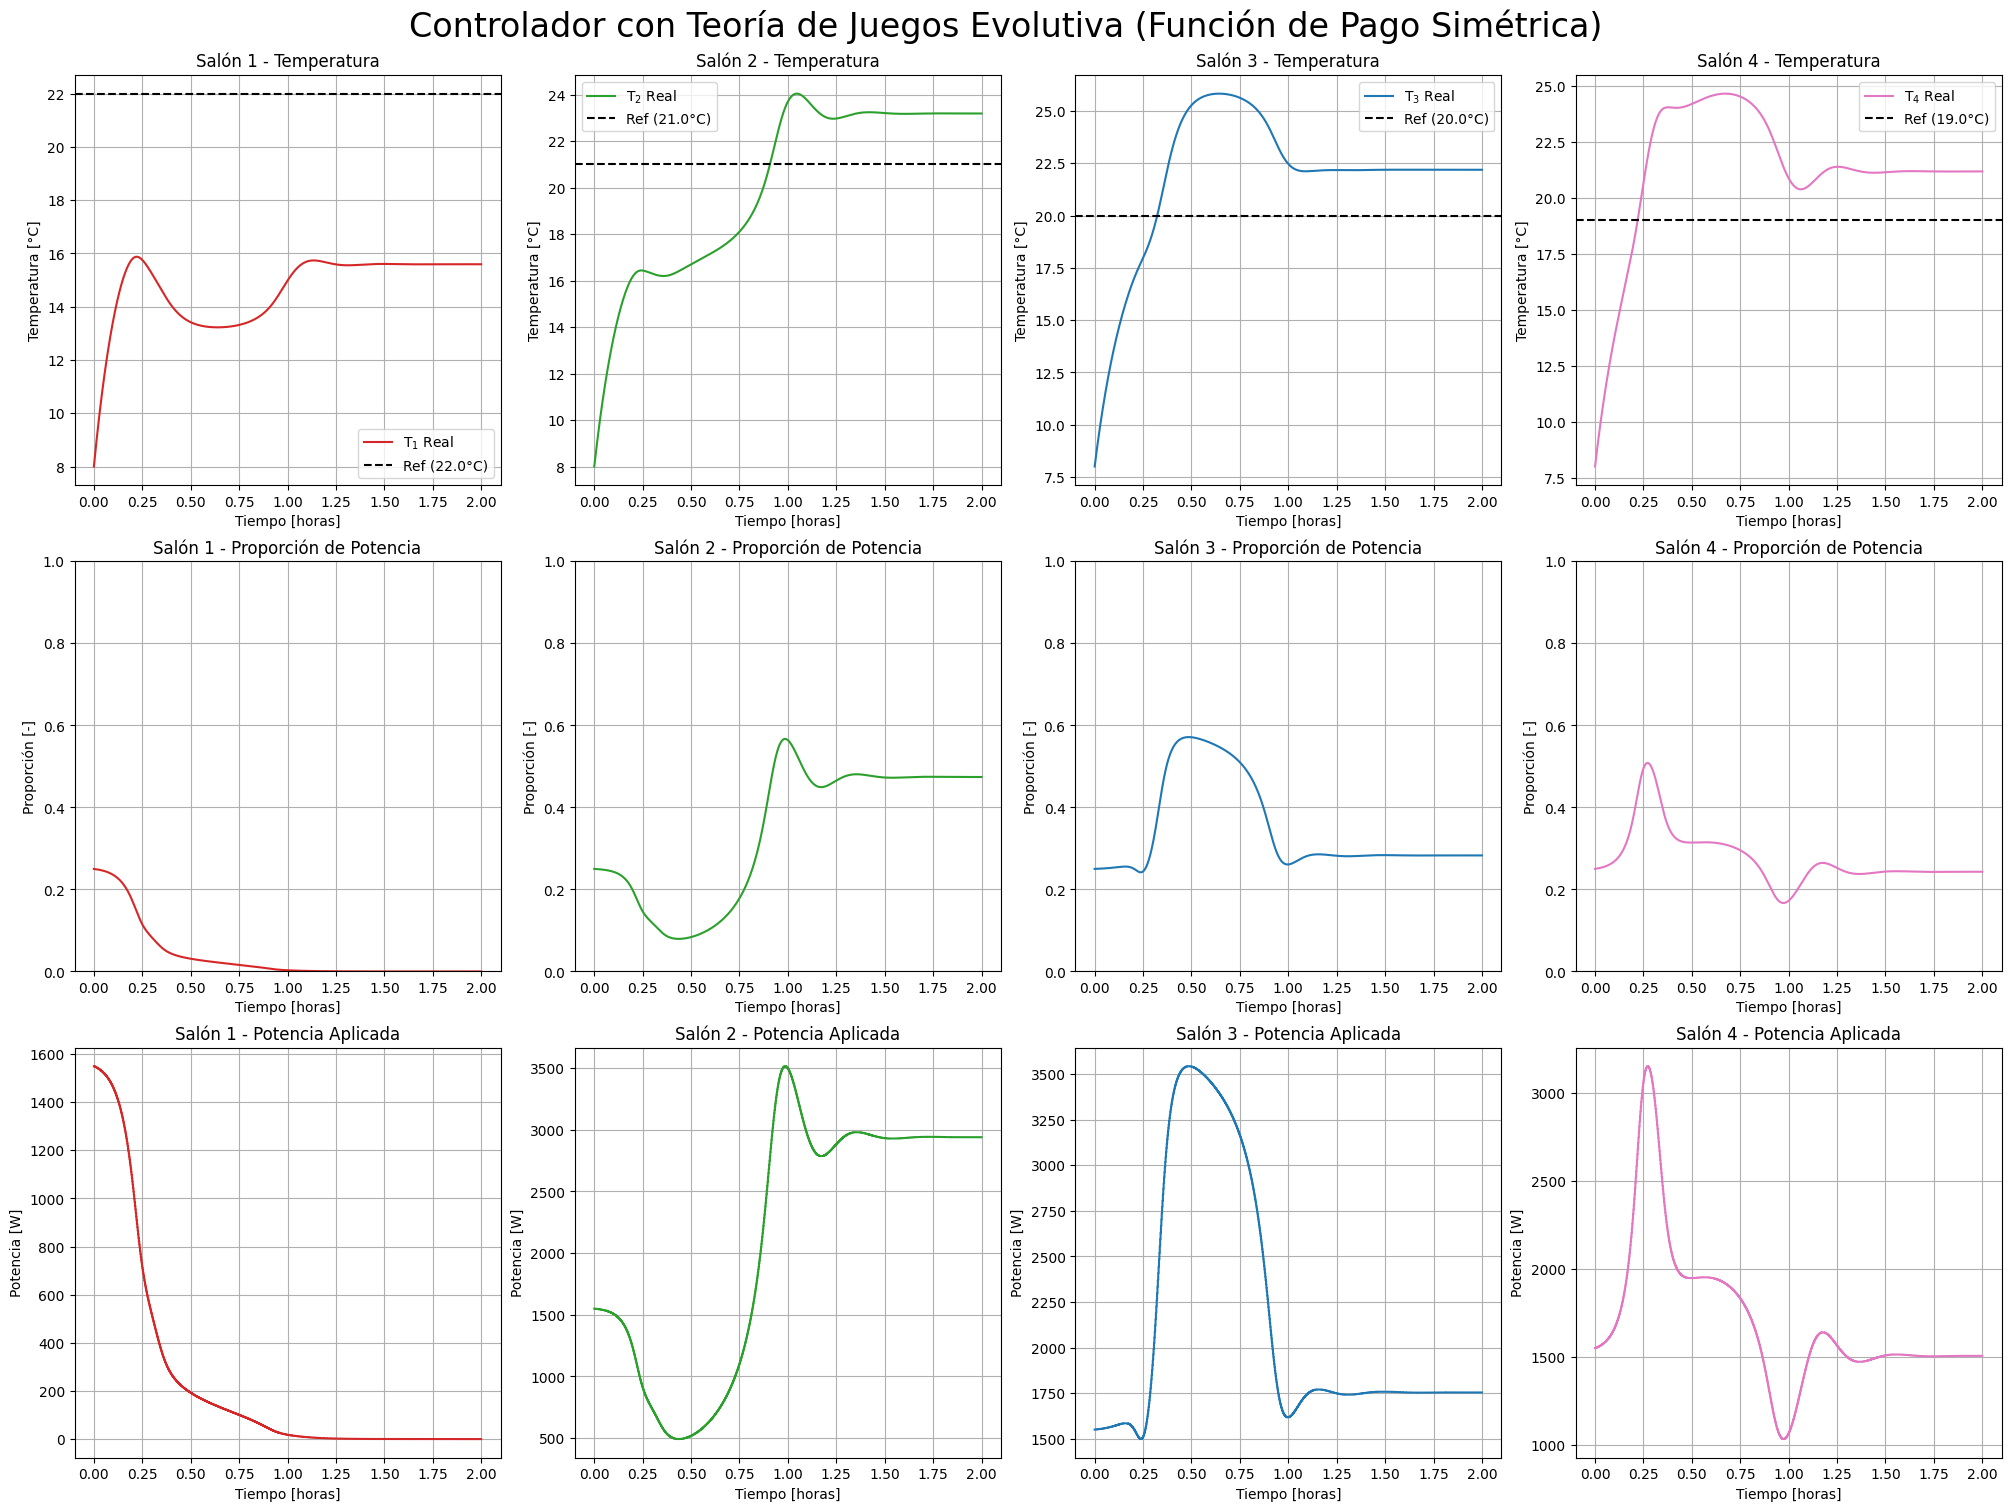

In [5]:
## ---- CONTROLADOR CON FUNCIÓN DE PAGO ASIMÉTRICA ----

# Fase 2.2: Diseño del Controlador de Teoría de Juegos (Con lógica de pago mejorada)
class ControladorTeoriaJuegos:
    def __init__(self, n_jugadores, u_max_total, k_replicator):
        self.n_jugadores = n_jugadores
        self.u_max_total = u_max_total
        self.k_replicator = k_replicator
        self.x = np.ones(n_jugadores) / n_jugadores

    def calcular_accion(self, t_actuales, t_ref, dt):
        
        # <-- CAMBIO CLAVE 2: Nueva función de pago asimétrica
        # El pago ahora es simplemente el error. Un error grande y positivo (muy frío)
        # da un pago alto, incentivando la acción. Un error negativo (muy caliente)
        # da un pago negativo, penalizando fuertemente y forzando una reducción de potencia.
        error = t_ref - t_actuales
        pagos = error
        
        # El resto de la lógica se mantiene
        pago_promedio = np.dot(self.x, pagos)
        dx_dt = self.x * (pagos - pago_promedio)
        
        x_nuevo = self.x + self.k_replicator * dt * dx_dt
        
        x_nuevo[x_nuevo < 0] = 0
        suma_x = np.sum(x_nuevo)
        if suma_x > 0:
            self.x = x_nuevo / suma_x
        else: # En caso de que todos los x se vuelvan cero, re-inicializar
            self.x = np.ones(self.n_jugadores) / self.n_jugadores
            
        u_control = self.x * self.u_max_total
        return u_control

print("Fase 2.2: Clase ControladorTeoriaJuegos actualizada con función de pago asimétrica.")

Fase 2.2: Clase ControladorTeoriaJuegos actualizada con función de pago asimétrica.


### Fase 3: Simulación en Lazo Cerrado

Ahora construimos el bucle de simulación que orquesta la interacción entre el controlador y la planta, tal como se hace en tu "Entrega 2".

In [6]:
%%time
# Fase 3: Simulación en Lazo Cerrado

# ---- Inicialización ----
# Vectores para almacenar resultados
T_hist = np.zeros((PASOS, 4))
U_hist = np.zeros((PASOS, 4))
X_hist = np.zeros((PASOS, 4)) # Para ver la evolución de las proporciones

# Condiciones iniciales
T_actual = np.full(4, T_A)
T_hist[0, :] = T_actual

# Instanciar el controlador
controlador = ControladorTeoriaJuegos(
    n_jugadores=4, 
    u_max_total=U_MAX_TOTAL, 
    k_replicator=K_REPLICATOR
)

print("Fase 3: Iniciando simulación en lazo cerrado...")

# ---- Bucle Principal de Simulación ----
for i in range(1, PASOS):
    t_span = [t_vector[i-1], t_vector[i]]
    
    # 1. Controlador calcula la acción de control
    u_actuales = controlador.calcular_accion(T_actual, T_REF_VALUES, DT)
    
    # 2. Construir vector de entrada para la planta
    u_planta = np.append(u_actuales, T_A)
    
    # 3. Simular la planta para el siguiente paso de tiempo
    T_siguiente = odeint(sistema_temperatura_edificacion, T_actual, t_span, args=(u_planta,))
    
    # 4. Actualizar el estado
    T_actual = T_siguiente[-1]
    
    # 5. Almacenar resultados
    T_hist[i, :] = T_actual
    U_hist[i-1, :] = u_actuales # La acción se aplica en el intervalo
    X_hist[i-1, :] = controlador.x

# La última acción de control se repite para que los vectores tengan el mismo tamaño
U_hist[-1, :] = U_hist[-2, :]
X_hist[-1, :] = X_hist[-2, :]

print("Simulación completada.")

Fase 3: Iniciando simulación en lazo cerrado...
Simulación completada.
CPU times: user 311 ms, sys: 6.69 ms, total: 318 ms
Wall time: 332 ms


### Fase 4: Visualización y Resultados

Finalmente, adaptamos las funciones de visualización y resumen de tu entrega anterior para mostrar los resultados de nuestro controlador.

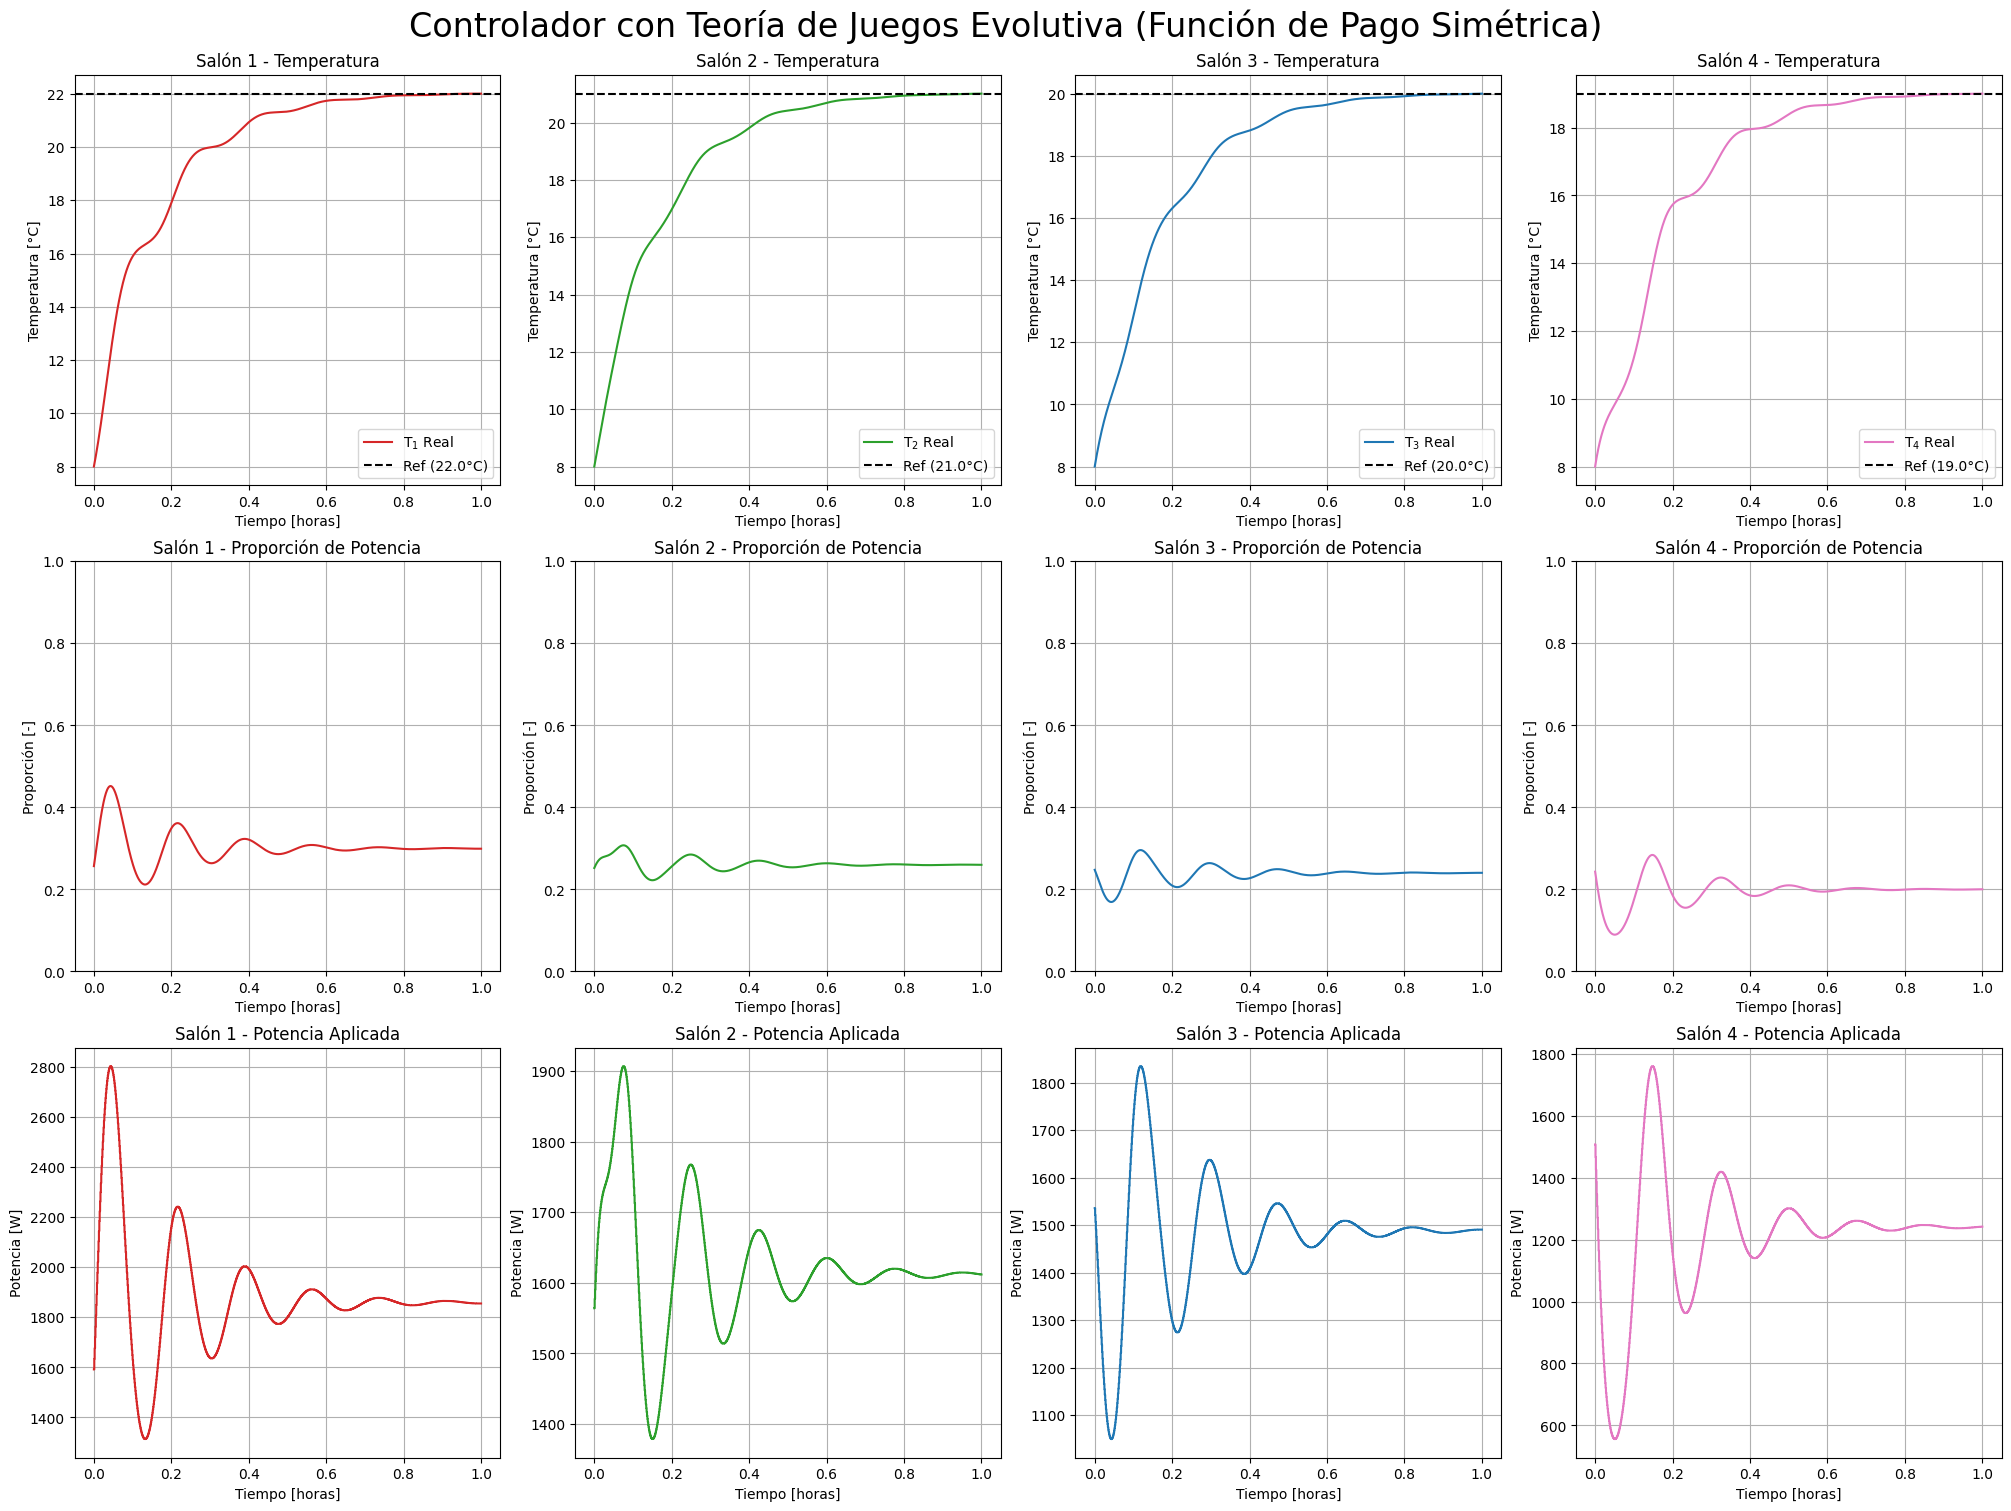


== RESUMEN DE RESULTADOS ==
Energía Total Consumida: 22.34 MJ

Valores finales por salón:
Salón 1: T_final=22.01°C | Error_final=-0.01°C | Potencia_media=1887.9 W
Salón 2: T_final=21.01°C | Error_final=-0.01°C | Potencia_media=1622.5 W
Salón 3: T_final=20.01°C | Error_final=-0.01°C | Potencia_media=1477.4 W
Salón 4: T_final=19.00°C | Error_final=-0.00°C | Potencia_media=1212.1 W


In [7]:
# Fase 4: Visualización y Análisis

# ---- 4.1 Función de Visualización (Adaptada de Entrega 2) ----
def plot_sim_results(t, T_hist, U_hist, X_hist, T_ref, title_prefix):
    fig, axs = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
    colors = ['#d62728', '#2ca02c', '#1f77b4', '#e377c2']
    titles = ['Salón 1', 'Salón 2', 'Salón 3', 'Salón 4']
    
    t_horas = t / 3600
    
    for i in range(4):
        # Gráfica de Temperatura
        ax_T = axs[0, i]
        ax_T.plot(t_horas, T_hist[:, i], color=colors[i], label=f'T$_{i+1}$ Real')
        ax_T.axhline(y=T_ref[i], color='k', linestyle='--', label=f'Ref ({T_ref[i]}°C)')
        ax_T.set_title(f'{titles[i]} - Temperatura')
        ax_T.set_ylabel('Temperatura [°C]')
        ax_T.set_xlabel('Tiempo [horas]')
        ax_T.legend()
        ax_T.grid(True)
        
        # Gráfica de Proporciones
        ax_X = axs[1, i]
        ax_X.plot(t_horas, X_hist[:, i], color=colors[i], label=f'x$_{i+1}$ (Proporción)')
        ax_X.set_title(f'{titles[i]} - Proporción de Potencia')
        ax_X.set_ylabel('Proporción [-]')
        ax_X.set_xlabel('Tiempo [horas]')
        ax_X.set_ylim(0, 1)
        ax_X.grid(True)
        
        # Gráfica de Potencia
        ax_U = axs[2, i]
        ax_U.step(t_horas, U_hist[:, i], where='post', color=colors[i], label=f'u$_{i+1}$')
        ax_U.set_title(f'{titles[i]} - Potencia Aplicada')
        ax_U.set_ylabel('Potencia [W]')
        ax_U.set_xlabel('Tiempo [horas]')
        ax_U.grid(True)

    fig.suptitle(title_prefix, fontsize=24)
    plt.show()

# ---- 4.2 Función de Resumen (Adaptada de Entrega 2) ----
def resumen_resultados(T_hist, U_hist, T_ref):
    print("\n== RESUMEN DE RESULTADOS ==")
    
    potencia_media = np.mean(U_hist, axis=0)
    energia_total_MJ = np.sum(U_hist * DT) / 1e6
    
    print(f"Energía Total Consumida: {energia_total_MJ:.2f} MJ")
    
    print("\nValores finales por salón:")
    for i in range(4):
        T_final = T_hist[-1, i]
        error_final = T_ref[i] - T_final
        print(f"Salón {i+1}: T_final={T_final:.2f}°C | Error_final={error_final:.2f}°C | Potencia_media={potencia_media[i]:.1f} W")

# ---- 4.3 Ejecutar Visualización y Análisis ----
plot_sim_results(t_vector, T_hist, U_hist, X_hist, T_REF_VALUES, 'Controlador con Teoría de Juegos Evolutiva (Función de Pago Simétrica)')
resumen_resultados(T_hist, U_hist, T_REF_VALUES)

In [8]:
import numpy as np
import pandas as pd 

def analisis_estado_estacionario_y_energia(t_vector, T_hist, U_hist, T_REF_VALUES, DT):
    print("\n== ANÁLISIS ADICIONAL DE ESTADO ESTACIONARIO Y ENERGÍA ==")
    
    n_jugadores = len(T_REF_VALUES)
    t_horas = t_vector / 3600
    T_FINAL_SECS = t_vector[-1] # T_FINAL en segundos
    
    # --------------------------------------------------------------------------------
    # 1. Tiempo de Establecimiento (Ts) - Se mantiene igual
    tolerancia_ts = 0.1 # Tolerancia absoluta de 0.1°C
    t_establecimiento = np.zeros(n_jugadores)
    
    for i in range(n_jugadores):
        T_ref = T_REF_VALUES[i]
        error_abs = np.abs(T_hist[:, i] - T_ref)
        
        Ts = t_horas[-1]
        for j in range(len(t_horas) - 1, 0, -1):
            if np.all(error_abs[j:] <= tolerancia_ts):
                Ts = t_horas[j]
            else:
                break
        t_establecimiento[i] = Ts
        
    # --------------------------------------------------------------------------------
    # Definición de la región de Estado Estacionario (CORRECCIÓN CLAVE)
    # Se usa el segmento de tiempo definido por el usuario: Últimos 2 segundos
    t_estacionario_inicio_secs = T_FINAL_SECS - 2.0
    if t_estacionario_inicio_secs < 0: t_estacionario_inicio_secs = 0.0
        
    # Encuentra el índice correspondiente al tiempo de inicio de SS (últimos 2 segundos)
    # np.where busca el primer índice donde el tiempo es mayor o igual al inicio
    indice_estado_estacionario = np.where(t_vector >= t_estacionario_inicio_secs)[0][0] 

    # --------------------------------------------------------------------------------
    # 2. Potencia aplicada en estado estacionario (Promedio en la región de SS)
    potencia_estado_estacionario = np.mean(U_hist[indice_estado_estacionario:, :], axis=0)

    # 3. Errores en estado estacionario (Error en el último instante, que es el más estable)
    T_final = T_hist[-1, :]
    error_estado_estacionario = T_REF_VALUES - T_final
    
    # 4. Amplitud máxima de oscilaciones en estado estacionario (en la región de SS)
    amplitud_oscilacion = np.zeros(n_jugadores)
    for i in range(n_jugadores):
        T_ss = T_hist[indice_estado_estacionario:, i]
        # Max - Min en la región de SS, dividido por 2
        amplitud_oscilacion[i] = (np.max(T_ss) - np.min(T_ss)) / 2.0
    
    # --------------------------------------------------------------------------------
    # 5. Energía consumida en la primera hora (total) en Mega Joules
    t_una_hora = 1.0
    # Encuentra el índice que corresponde a 1 hora (3600 segundos)
    indice_una_hora = np.where(t_horas >= t_una_hora)[0][0]
    
    energia_primera_hora_MJ = np.sum(U_hist[0:indice_una_hora, :]) * DT / 1e6
    
    # Mostrar resultados
    for i in range(n_jugadores):
        print(f"Salón {i+1}:")
        # Ts se reporta en minutos
        print(f"  1. Tiempo de Establecimiento (Ts): {t_establecimiento[i] * 60:.2f} min")
        print(f"  2. Potencia Est. Estacionario: {potencia_estado_estacionario[i]:.1f} W")
        # Error Est. Estacionario
        print(f"  3. Error Est. Estacionario: {error_estado_estacionario[i]:.2f} °C") 
        # Amplitud Máx. Oscilaciones Est. Estacionario
        print(f"  4. Amplitud Máx. Oscilaciones Est. Estacionario: {amplitud_oscilacion[i]:.4f} °C")
        
    print(f"\n5. Energía Total Consumida en la Primera Hora: {energia_primera_hora_MJ:.2f} MJ")
    
# La función guardar_datos_csv permanece igual.

# Función para guardar datos en CSV (Se mantiene sin cambios)
def guardar_datos_csv(t_vector, T_hist, U_hist):
    import os
    # Crear un diccionario para los datos
    data = {'Tiempo (horas)': t_vector / 3600}
    
    for i in range(T_hist.shape[1]): 
        data[f'Temperatura_Salon_{i+1} (C)'] = T_hist[:, i]
        data[f'Potencia_Salon_{i+1} (W)'] = U_hist[:, i] 
        
    df = pd.DataFrame(data)
    os.makedirs('../data', exist_ok=True)
    nombre_archivo = 'datos_simulacion_EGT.csv'
    ruta_completa = os.path.join('../data', nombre_archivo)
    df.to_csv(ruta_completa, index=False)
    print(f"\nDatos de simulación guardados en {ruta_completa}")

In [9]:
analisis_estado_estacionario_y_energia(t_vector, T_hist, U_hist, T_REF_VALUES, DT)


== ANÁLISIS ADICIONAL DE ESTADO ESTACIONARIO Y ENERGÍA ==
Salón 1:
  1. Tiempo de Establecimiento (Ts): 44.80 min
  2. Potencia Est. Estacionario: 1855.2 W
  3. Error Est. Estacionario: -0.01 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C
Salón 2:
  1. Tiempo de Establecimiento (Ts): 45.71 min
  2. Potencia Est. Estacionario: 1611.8 W
  3. Error Est. Estacionario: -0.01 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C
Salón 3:
  1. Tiempo de Establecimiento (Ts): 46.25 min
  2. Potencia Est. Estacionario: 1490.8 W
  3. Error Est. Estacionario: -0.01 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C
Salón 4:
  1. Tiempo de Establecimiento (Ts): 43.96 min
  2. Potencia Est. Estacionario: 1242.3 W
  3. Error Est. Estacionario: -0.00 °C
  4. Amplitud Máx. Oscilaciones Est. Estacionario: 0.0000 °C

5. Energía Total Consumida en la Primera Hora: 22.32 MJ


In [10]:
guardar_datos_csv(t_vector, T_hist, U_hist)


Datos de simulación guardados en ../data/datos_simulacion_EGT.csv


### Fase 5: Análisis de Resultados

- El controlador EGT es un controlador de comportamiento suave como se observa no solo en las graficas de temperatura sino también de potencia, haciendo un controlador que contribuye al cuidado de los actuadores al disminuir (o en este caso) eliminar los cambios bruscos de potencia. Además, la cantidad de oscilaciones representativas no superan las 6 oscilaciones en un tiempo de una hora, lo que lo hace aún más eficiente al disminuir el desgaste del sistema.

- Por otro lado, se observa que le toma alrededor de 45min llegar al estado estacionario, donde el error es realmente pequeño (-0.01 °C) y las oscilaciones son nulas (amplitud = 0 °C). Esto último es ideal en un sistema que busca extender la vida útil de un actuador, sin embargo, el tiempo de establecimiento es significativamente más alto comparado con otros actuares como el MPC (tiempo de establecimiento ~ 6min). A pesar de esta desventaja, se debe reconocer que a los 12 min, el error máximo para cualquier habitación es menor a los 3 °C, por lo que el controlador tiene una respuesta relativamente rápida (crecimiento acelerado al inicio) y luego sufre una desaceleración al empezar a acercarse a la temperatura de referencia. Para muchas aplicaciones de calefactores, este error menor a 3 °C en un tiempo de 12min, puede ser más que suficiente.

- Otro factor importante a destacar fue la fácilidad de implementación de este controlador, de hecho, al principio se implementó una función de pago lógistica simétrica que no logró el objetivo ya que hacía que la temperatura no se alcanzara para el salón (por debajo) mientras que se sobrepasaba para los otros salones, en ningún caso llegando a la temperatura de referencia. Además incluía cambios bruscos en la temperatura de cada habitación (hasta 6 °C por encima de la temperatura deseada), y el tiempo de establecimiento estaba por encima de la hora. Posteriormente se implementó la función de pago más simple posible que es asimétrica, la cual corrigió todos los problemas y lo unico que se debió hacer fue afinar los hiperparametros del sistema, que para este caso son la potencia máxima (potencia máxima ajustada = 6200 W) y el replicador (K = 0.005).

- Finalmente, la energía consumida durante la primera hora (22.32 MJ) es una energía bastante eficiente, muy por debajo de los cientos de mega joules consumidos por el controlador difuso. En consumo energético es algo a tener en cuenta en todos los sistemas, pero en espacial en los sistemas de calefacción donde la inercia térmica de los sistemas aumentan los tiempos de uso de cada dispotivo.

**Posibles mejoras**

- Se podrian explorar más funciones de pago, por ejemplo, alguna función de pago que sea predictiva como ocurre en el controlador MPC y no una reactiva como usa este actual controlador de EGT.
- También se podría intentar no utilizar un replicador (K) constante sino adaptativo, con el fin de disminuir aún más las oscilaciones y acelerando la llegada a las temperaturas de referencia.